In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

### Banded matrices 

Let us consider two different banded matrices that arise from partial differential equations. 


The first matrix is tridiagonal

$$ A = \begin{bmatrix} 2 & -1 \\ -1 & 2 & -1 \\  & \dots & \dots & \dots \\ & & -1 & 2\end{bmatrix} $$ 

and arises from finite differences on a 1D Poisson's equation
$$ - u^{''}(x) = f(x) \qquad u(0) = u(1) = 0 $$ 


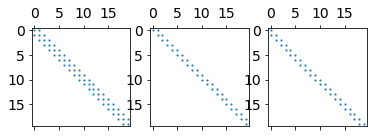

In [2]:
from scipy.sparse import spdiags, eye, kronsum
import scipy.linalg as sl

n = 20
e = np.ones((n,))
A = spdiags([-e,2*e,-e], [-1,0,1], n, n)


Ad = A.todense()
p,l,u = sl.lu(Ad, permute_l=False)

f, (ax1,ax2,ax3) = plt.subplots(1,3)
ax1.spy(A, markersize = 1)
ax2.spy(u, markersize = 1)
ax3.spy(l, markersize = 1)

The second matrix $B$ has 5 nonzero diagonals and arises from 2D Poisson's equation,
$$ -\Delta u = f ,$$

with Dirichlet boundary conditions. This gives the following sparse matrix:


$$ B = A \otimes I + I \otimes A ,$$

where $\otimes$ is the Kronecker product. 

In [3]:
n = 3
e = np.ones((n,))
A = spdiags([-e,2*e,-e], [-1,0,1], n, n)
B = kronsum(A, A)

print(B.todense())

[[ 4. -1.  0. -1.  0.  0.  0.  0.  0.]
 [-1.  4. -1.  0. -1.  0.  0.  0.  0.]
 [ 0. -1.  4.  0.  0. -1.  0.  0.  0.]
 [-1.  0.  0.  4. -1.  0. -1.  0.  0.]
 [ 0. -1.  0. -1.  4. -1.  0. -1.  0.]
 [ 0.  0. -1.  0. -1.  4.  0.  0. -1.]
 [ 0.  0.  0. -1.  0.  0.  4. -1.  0.]
 [ 0.  0.  0.  0. -1.  0. -1.  4. -1.]
 [ 0.  0.  0.  0.  0. -1.  0. -1.  4.]]


However, $B$ is stored in sparse format.

In [4]:
import scipy.sparse as ssp
print(ssp.find(B))

(array([0, 1, 3, 0, 1, 2, 4, 1, 2, 5, 0, 3, 4, 6, 1, 3, 4, 5, 7, 2, 4, 5,
       8, 3, 6, 7, 4, 6, 7, 8, 5, 7, 8], dtype=int32), array([0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5,
       5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8], dtype=int32), array([ 4., -1., -1., -1.,  4., -1., -1., -1.,  4., -1., -1.,  4., -1.,
       -1., -1., -1.,  4., -1., -1., -1., -1.,  4., -1., -1.,  4., -1.,
       -1., -1.,  4., -1., -1., -1.,  4.]))


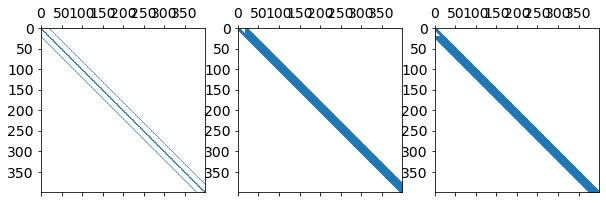

In [15]:
n = 20
e = np.ones((n,))
A = spdiags([-e,2*e,-e], [-1,0,1], n, n)
B = kronsum(A, A)

Bd = B.todense()
p,l,u = sl.lu(Bd, permute_l=False)

f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (10,5))
ax1.spy(B, markersize = 0.1)
ax2.spy(u, markersize = 1)
ax3.spy(l, markersize = 1)

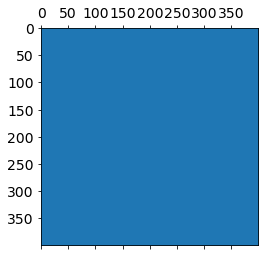

In [17]:
plt.spy(np.linalg.inv(Bd),markersize = 1)

## Sparse matrices

A wonderful collection of sparse matrices is available at [SuiteSparse](https://sparse.tamu.edu/). Here is another great one [Matrix Market](https://math.nist.gov/MatrixMarket/).

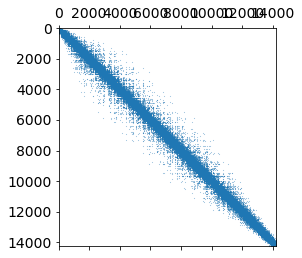

In [6]:
from scipy.io import mmread, loadmat
from scipy.sparse.linalg import splu
from scipy.sparse import csc_matrix

A = mmread('airfoil_2d.mtx')
A = csc_matrix(A)
plt.spy(A, markersize = 0.1)

In [20]:
print(A.nnz)
print(A.shape[0]*A.shape[1])
print(A.nnz/(A.shape[0]*A.shape[1]))

58
400
0.145


### LU factorization

Suppose we ignore the sparsity and treat it as a dense matrix.

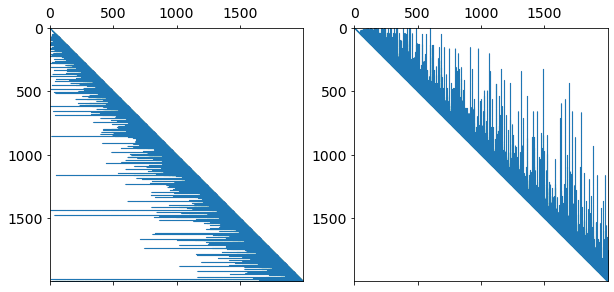

In [8]:
f, (ax1,ax2) = plt.subplots(1,2, figsize = (10,5))

from scipy.linalg import lu_factor, lu

Ad = A.todense()[:2000,:2000]
p,l,u = lu(Ad, permute_l=False)


ax1.spy(l, markersize = 0.1)
ax2.spy(u, markersize = 0.1)

#### Cost to compute LU factors

In [9]:
%timeit lu(A.todense()[:4000,:4000], permute_l = False)

555 ms ± 19.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Computing using a Sparse LU factorization

Method is  NATURAL
CPU times: user 548 ms, sys: 19.2 ms, total: 567 ms
Wall time: 569 ms
Method is  MMD_ATA
CPU times: user 964 ms, sys: 162 ms, total: 1.13 s
Wall time: 290 ms
Method is  COLAMD
CPU times: user 967 ms, sys: 159 ms, total: 1.13 s
Wall time: 290 ms


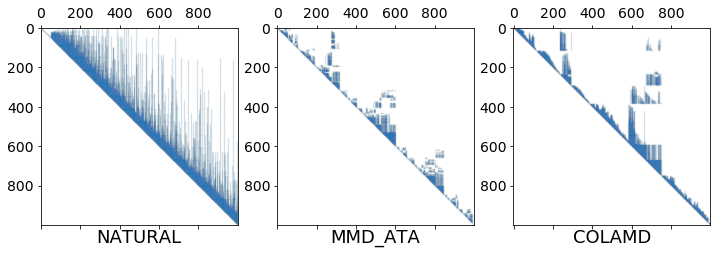

In [10]:
methods = ['NATURAL', 'MMD_ATA', 'COLAMD']

f, axarray = plt.subplots(1,3, sharex = True, sharey = False, figsize = (12,4))

for j, ax  in enumerate(axarray.flatten()):
    print('Method is ', methods[j])
    fact = splu(A, permc_spec = methods[j])
    
    %time splu(A, permc_spec = methods[j])
    
    ax.spy(fact.U[:1000,:1000], markersize = 0.01)
    ax.set_xlabel(methods[j], fontsize = 18)